In [1]:
import glob
import os
import pandas as pd
import numpy as np
import json
import math
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import random
import collections

from datetime import date, timedelta

from PIL import Image
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

import torch
from torch import nn, optim
from torchvision import transforms
# import torchtext
from torch.utils.data import Dataset, DataLoader, BatchSampler
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
%matplotlib inline

import gc
from train_coco import RuCLIPtiny, Predictor

def make_tg_report(text) -> None:
    token = '6498069099:AAFtdDZFR-A1h1F-8FvOpt6xIzqjCbdLdsc'
    method = 'sendMessage'
    chat_id = 324956476
    _ = requests.post(
            url='https://api.telegram.org/bot{0}/{1}'.format(token, method),
            data={'chat_id': chat_id, 'text': text}
        ).json()


device = 'cuda:0'
make_tg_report('загрузились импорты')

/home/exponenta_ds/pyenvs/ruclip/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# %pip install transformers opencv-python tqdm scikit-learn sentence-transformers torchtext
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [5]:
import os
for filename in os.listdir():
    root, ext = os.path.splitext(filename)
    if root.startswith('cc12m_3mill') and ext == '.pt':
        to_load = filename
        
print(to_load)

cc12m_3mill_ep_23.pt


In [2]:
ruclip_tiny = RuCLIPtiny()
models_dir = 'train_results/'
std = torch.load(models_dir + 'cc12m_ddp_4mill_ep_4.pt', weights_only=True)
ruclip_tiny.load_state_dict(std)
ruclip_tiny = ruclip_tiny.to(device)
ruclip_tiny.eval()

RuCLIPtiny(
  (visual): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw): Conv2

In [3]:
predictor = Predictor()

/home/exponenta_ds/pyenvs/ruclip/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
data_path = 'data/'
path =  data_path+'data-from-mpstats-irina/new/data_scores.csv'
sku_names = pd.read_csv(path)[['sku_first', 'sku_second', 'name_first', 'name_second', 'y']]

path = data_path+'indeepa-images/'
sku_to_imgpath = {}
with os.scandir(path + 'images_labeled') as it:
    for entry in it:
        if entry.is_file():
            sku_to_imgpath.update({int(entry.name[:-4]):entry.path})

In [7]:
# prepare classes
names = list()
images = list()
for row in sku_names.iterrows():
    row = row[1]
    imgpath1, imgpath2 = sku_to_imgpath[row.sku_first], sku_to_imgpath[row.sku_second]
    name1, name2 = row.name_first, row.name_second
    names.append(name1)
    names.append(name2)
    images.append(Image.open(imgpath1))
    images.append(Image.open(imgpath2))

In [8]:
test_slice = [200, 210]

images_test = images[test_slice[0]:test_slice[1]]
texts_test = names[test_slice[0]:test_slice[1]]
images_latents = predictor.prepare_images_features(ruclip_tiny, images, device=device)
text_latents = predictor.prepare_text_features(ruclip_tiny, names, device=device)

In [9]:
def cos_sim(a, b):
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

In [10]:
text_sims = []
image_sims = []
for ind in range(0, text_latents.shape[0], 2):
    first = text_latents[ind].cpu()
    second = text_latents[ind + 1].cpu()
    text_sims.append(cos_sim(first, second))
    
    first = images_latents[ind].cpu()
    second = images_latents[ind + 1].cpu()
    image_sims.append(cos_sim(first, second))
    
merged = np.c_[images_latents.cpu(), text_latents.cpu()]
merged_sims = list()
for ind in range(0, text_latents.shape[0], 2):
    first = merged[ind]
    second = merged[ind + 1]
    merged_sims.append(cos_sim(first, second))

In [11]:
names = np.array(names)
names_first = names[range(0, names.shape[0]-1, 2)]
names_second= names[range(1, names.shape[0], 2)]

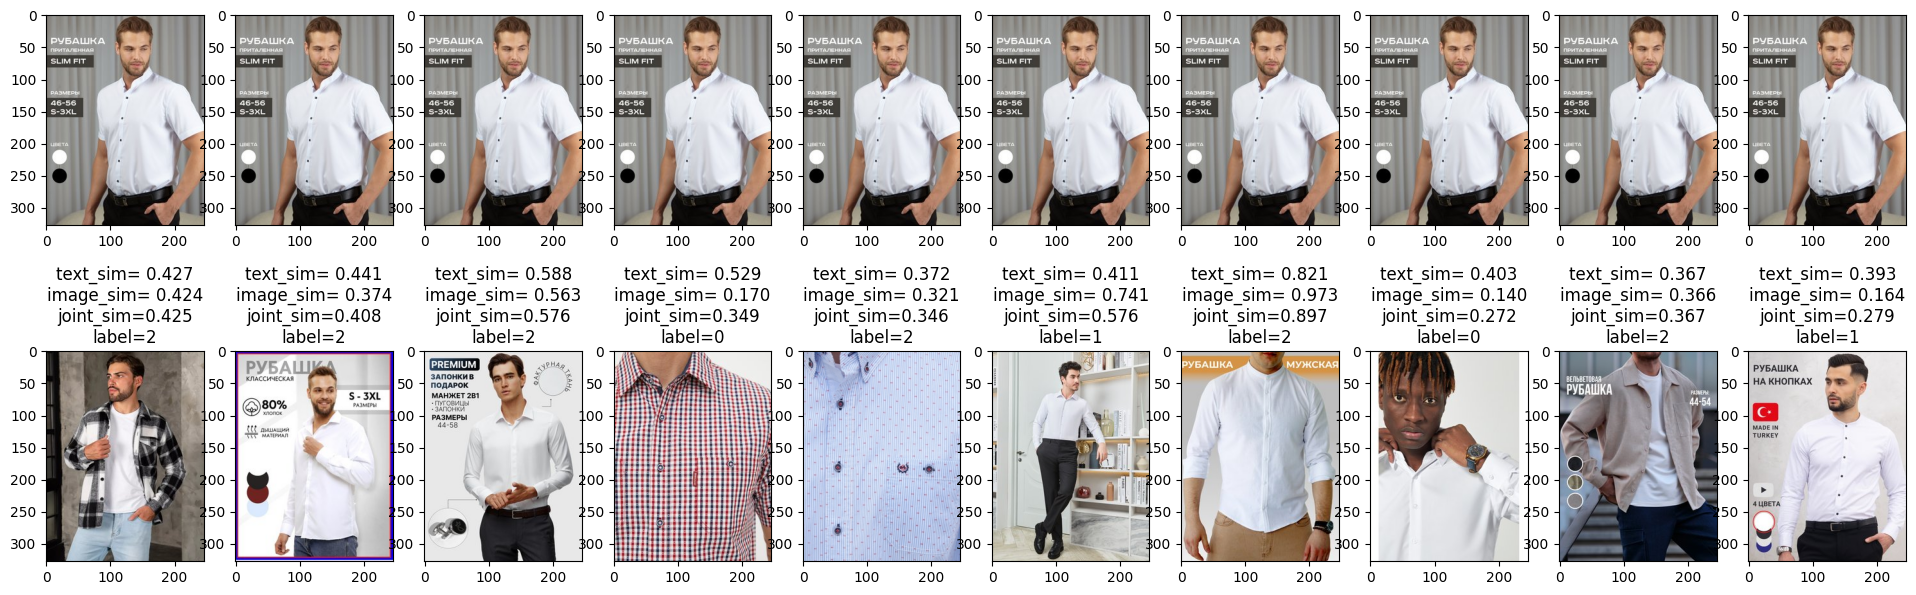

In [12]:
num_to_show = test_slice[1]-test_slice[0]
offset = test_slice[0]
_, ax = plt.subplots(2, num_to_show, figsize=(24, 8))
for i in range(num_to_show):
    ax[0, i%num_to_show].imshow(images[2*i + offset])
    # ax[0, i%num_to_show].set_title(names[2*i+offset])
    ax[1, i%num_to_show].imshow(images[2*i+1 + offset])
    ax[1, i%num_to_show].set_title(f'text_sim= {text_sims[i+ offset]:.3f}\nimage_sim= {image_sims[i+ offset]:.3f}\njoint_sim={merged_sims[i+ offset]:.3f}\nlabel={sku_names.iloc[i+ offset].y}')

In [13]:
idx = test_slice[0]//2+2
names_first[idx], names_second[idx]

('Рубашка с коротким рукавом летняя',
 'Рубашка классическая приталенная с запонками')

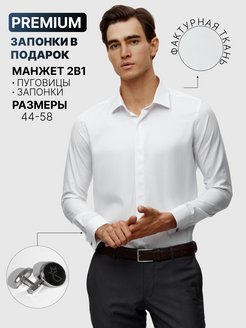

In [14]:
images[test_slice[0]+2*2+1]

In [15]:
make_tg_report('ready')